In [1]:
import torch
import matplotlib.pyplot as plt
from src.experiments.conditioned.dataset.config import DatasetConfig
from src.experiments.conditioned.dataset.dataset import Dataset
from src.experiments.conditioned.cunet.config import ModelConfig
from src.experiments.conditioned.cunet.model import Model
from tqdm import trange
import cv2 as cv
import numpy as np

In [61]:
dataset = Dataset(DatasetConfig(input_size=(512, 512), data_dir="./data/small/test", encoder_depth=4, max_angle=360, sample_interval=1))

In [62]:
config = ModelConfig(start_channels=64)
model1 = Model(config, dropout=0)
# ckpt = 'best_loss'
ckpt = 'last'
_ = model1.cuda()
model1.load_ckpt(f'./outputs/cunet/lightning_logs/version_9/checkpoints/{ckpt}.ckpt')

In [63]:
def get_object_helper(object_id, i):
    with torch.inference_mode():
        (x, z), y = dataset.get_for_prediction(object_id, i)
        y = y.numpy()[0]
        x = x.numpy()
        z = z.numpy()
        x_ = torch.tensor(x, device="cuda", requires_grad=False)[None, ...]
        z_ = torch.tensor(z, device="cuda", requires_grad=False)[None, ...]
        pred1 = model1(x_, z_).cpu().numpy()[0, 0]
    imgs_title = [(x[0], "left"),
    (x[1], "right"),
    (pred1, "predicted"),
    (y, "ground truth")]
    return imgs_title

def get_object(object_id, tqdm=True):
    outputs = []
    if tqdm:
        for i in trange(360, desc="predicting projections"):
            outputs.append(get_object_helper(object_id, i))
    else:
        for i in range(360):
            outputs.append(get_object_helper(object_id, i))
    return outputs

In [80]:
outputs = get_object(5)

predicting projections: 100%|██████████| 360/360 [00:17<00:00, 20.14it/s]


In [81]:
w_name = "out"
window = cv.namedWindow(w_name)
for out in outputs:
    imgs = [x[0] for x in out]
    img = np.concatenate(imgs, axis=1)
    # img = cv.resize(img, (None, None), fx=2, fy=2)
    img[img > 1] = 1
    img[img < 0] = 0
    cv.imshow(w_name, img)
    if cv.waitKey(60) == 27:
        break
cv.destroyWindow(w_name)

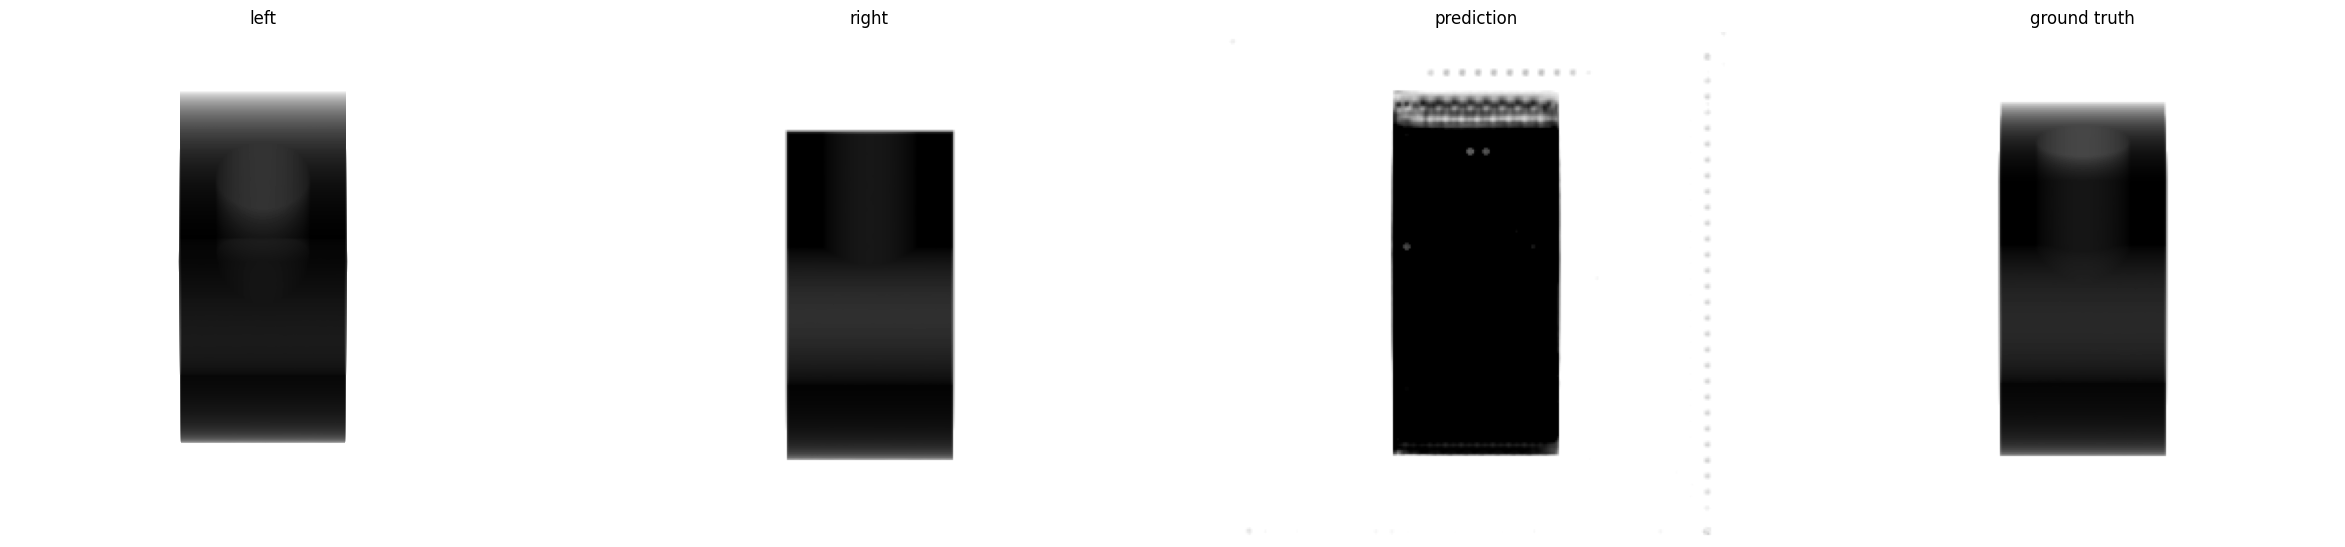

In [74]:
angle = 70
object_id = 5
resize = lambda x: cv.resize(x, (256, 256))
with torch.inference_mode():
    (x, z), y = dataset.get_for_prediction(object_id, angle)
    y = y.numpy()[0]
    x = x.numpy()
    z = z.numpy()
    x_ = torch.tensor(x, device="cuda", requires_grad=False)[None, ...]
    z_ = torch.tensor(z, device="cuda", requires_grad=False)[None, ...]
    pred1 = model1(x_, z_).cpu().numpy()[0, 0]
    pred1 = resize(pred1)
imgs_title = [(x[0], "left"),
(resize(x[1]), "right"),
(resize(pred1), "prediction"),
# (pred2, "l1 loss"),
(resize(y), "ground truth")]
axs = plt.subplots(1, len(imgs_title), figsize=(30, 10))[1]
for ax, (img, title) in zip(axs, imgs_title):
    img[img > 1] = 1
    img[img < 0] = 0
    ax.imshow(img, cmap='gray')
    ax.set_title(title)
    ax.set_axis_off()